# data availability mapping

This notebook generates plots to illustrate data avaialbility from different data sources. 

1) An overview of how many years of data are available for each gas/sector pair for an individual country.  
2) An overview of the level of data available in each year for a set of countries.

**TODO: Check with other data sources, currently running with UNFCCC data from PRIMAP**

In [10]:
# import modules needed

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re, os
from shortcountrynames import to_name
%matplotlib inline

from countrygroups import UNFCCC

# specs for plotting
boldfont = {'fontsize': 11,
            'fontweight': 'bold',
            'verticalalignment': 'baseline'}

In [11]:
# USER SPECIFICATIONS

dataSource = 'UNFCCC'

filename = "UNFCCC2006DATA_PRIMAPunfccc_26-Apr-2019.csv"
category_set = 'IPCC2006'

# filename = "UNFCCC1996DATA_PRIMAPunfccc_26-Apr-2019.csv"
# category_set = 'IPCC1996'

# Select countries to analyse (ISO3 country codes)
countries_of_interest = ['EU', 'IND', 'MEX', 'VNM', 'ETH']                  


In [12]:
# read-in and tidy data

# actually read the data
datafile = os.path.join('input-data', 'availability', filename)
data = pd.read_csv(datafile)

# set here the order that we want the sectors to be plotted in
if category_set == 'IPCC1996':
    sectorOrder = ['Energy', 'Industrial Processes', 'Solvents/Product Use',
                   'Agriculture', 'Land Use', 'Waste', 'Other']
elif category_set == 'IPCC2006':
    sectorOrder = ['Energy', 'IPPU', 'AFOLU', 'Agriculture', 'Land Use', 'Waste', 'Other']
elif category_set == 'PRIMAPhist':
    sectorOrder = ['Energy', 'IPPU', 'AFOLU', 'Agriculture', 'Land Use', 'Waste', 'Other']
else:
    print('Category set is not defined! please check and add if needed!')
    
# convert all years to numbers
for col in data.columns:
    if col.startswith('Y'):
        data = data.rename(columns={col: col[1:]})

# drop extraneous columns
if 'Unnamed: 34' in data.columns:
    data = data.drop('Unnamed: 34', axis=1)

# CountryISO
data = data.rename(columns={'countryISO': 'countries'})
data = data.rename(columns={'categoryName': 'sector'})
data = data.rename(columns={'category': 'sector'})
data = data.rename(columns={'Entity': 'variable'})

# for conversion to short names, EU28 should be EU
data.loc[data['countries'] == 'EU28', ['countries']] = 'EU'

# convert category names to something shorter
category_dict = {
        'Other': 'Other',
        'Energy': 'Energy',
        'TotalEnergy': 'Energy',
        'LULUCF': 'Land Use',
        'NationalTotal': 'Total',
        'IndustrialProcessesAndProductUse': 'IPPU',
        'Waste': 'Waste',
        'Agriculture': 'Agriculture',
        'AFOLU': 'AFOLU',
        'SolventAndOtherProductUse' : 'Solvents/Product Use',
        'IndustrialProcesses': 'Industrial Processes'
    }

data['sector'] = data['sector'].apply(category_dict.get)

# don't need these two
#data = data.loc[data['variable'] != 'KYOTOGHGAR4']
#data = data.loc[data['sector'] != 'Total']

# make a 'mask' of data availability to see where data is available - all data just ones or zeros
year_columns = [y for y in data[data.columns] if (re.match(r"[0-9]{4,7}$", str(y)) is not None)]
mask_data = data.copy()
mask_data[year_columns] = mask_data[year_columns].notnull()
#mask_data

# get list of data available
gases = data.variable.unique()
sectors = data.sector.unique()
countries = data.countries.unique()

# count the number of data points available for each country
country_results = mask_data.groupby('countries').sum()
country_results = country_results.reset_index()
    

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


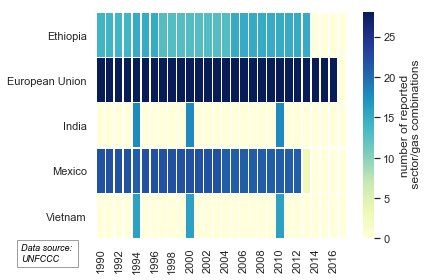

In [13]:
# Plot 1 - overview of data by country

# ===================
# DATA ANALYSIS AND PLOTS

# Prepare a sub-set of data to plot
results_to_plot = country_results.loc[country_results['countries'].isin(countries_of_interest)]

# set the index so it's automatically a y axis label
results_to_plot['countries'] = results_to_plot['countries'].apply(to_name)
results_to_plot = results_to_plot.set_index('countries')

# actually make a plot
ax = sns.heatmap(results_to_plot[year_columns], linewidths=.25, annot=False, cmap="YlGnBu",
                cbar_kws={'label': ('number of reported\n sector/gas combinations')})
                
ax.set_ylabel('')
ax.set_xlabel('')
#ax.set_title('Data availability by year \n (number of sectors and gases covered)', fontdict=boldfont)
plt.tight_layout()

ax.annotate(("Data source: \n" + dataSource),
                 xy=(-0.3, -0.1), xycoords=ax.transAxes,
                 fontsize=9, color='black', style='italic',
                 bbox=dict(facecolor='white', edgecolor='grey', alpha=0.75))


# save figure to file
figname = os.path.join('output', 'data-availability', ('years-of-data-by-country-' + dataSource))
plt.savefig((figname + '.pdf'), format='pdf', dpi=800)


In [14]:
# Plot 2 - overview of data by years for many countries
# ============================

sns.set(style="darkgrid")

sectors = data.sector.unique()
gases = data.variable.unique()

# get the data for this country
country_data = mask_data.loc[mask_data['countries'].isin(countries_of_interest)]

# drop un-needed columns
# get year columns
year_cols = [y for y in mask_data[mask_data.columns] if (re.match(r"[0-9]{4,7}$", str(y)) is not None)]
start_year = min(sorted(year_cols, key=int))

# get other columns
other_cols = list(set(mask_data.columns) - set(year_cols))
cols_to_drop = list(set(other_cols) - set(['countries', 'sector', 'variable']))
country_data = country_data.drop(cols_to_drop, axis=1)

# convert format to a matrix of available data, counting the number of years with data
data_matrix = country_data.set_index(['countries', 'sector', 'variable'])
data_matrix['yearsOfData'] = data_matrix.sum(axis=1)
data_matrix = data_matrix.drop(year_columns, axis=1)
data_matrix = data_matrix.unstack('variable')
data_matrix.columns = data_matrix.columns.droplevel()

# drop unwanted columns, and reorder columns for tidier plot
#data_matrix = data_matrix[['CO2', 'CH4', 'N2O']]
if 'NF3' in gases:
    data_matrix = data_matrix[['CO2', 'CH4', 'N2O', 'HFCS', 'PFCS', 'SF6', 'NF3']]
else: 
    data_matrix = data_matrix[['CO2', 'CH4', 'N2O', 'HFCS', 'PFCS', 'SF6']]
data_matrix


# make a mask where data isn't expected? (nan instead of 0)
# EU_mask = data_matrix.copy()
# EU_mask = EU_mask.loc['CHE', :]
# EU_mask = EU_mask.isnull()
# EU_mask = EU_mask.reindex(sectorOrder)

# # replace nans with zeros:
# data_matrix = data_matrix.fillna(0)


for selected_country in countries_of_interest:

    if selected_country in data_matrix.index:

        # Use to build new dataframe for selected country
        data_available = data_matrix.loc[selected_country, :]
        data_available = data_available.reindex(sectorOrder)
        
        # make a plot
        ax = sns.heatmap(data_available, linewidths=.25, annot=True, cmap="viridis_r", vmin=0,
                         vmax=28, cbar_kws={'label': ('Years of data since ' + start_year)})
                        #, mask=EU_mask)
                
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.set_title(to_name(selected_country), fontdict=boldfont)
        plt.tight_layout()

#         ax.annotate(("Data source: \n" + dataSource),
#                  xy=(-0.2, -0.1), xycoords=ax.transAxes,
#                  fontsize=9, color='black', style='italic',
#                  bbox=dict(facecolor='white', edgecolor='grey', alpha=0.75))

        # and save to file
        figname = 'output/data-availability/gas-sector-availability-' + to_name(selected_country) + '-' + dataSource

    #    plt.savefig((figname + '.png'), format='png', dpi=800)
        plt.savefig((figname + '.pdf'), format='pdf', dpi=800)
    #    plt.savefig((figname + '.eps'), format='eps')

        # clear plot or labels are repeated..
        plt.close()
        
    else:
        print('sorry, ' + selected_country + ' is not available.')
    

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


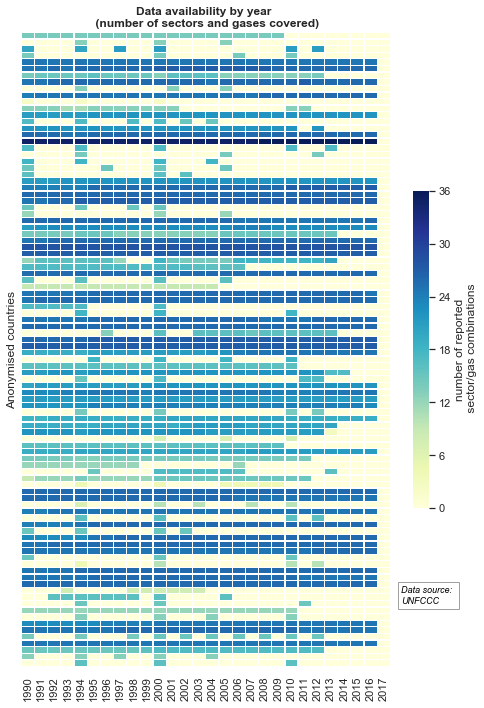

In [15]:
# Plot 3 - aggregate version, using all countries available

# use all countries in UNFCCC
all_unfccc_countries = data['countries'].loc[data['countries'].isin(UNFCCC)].unique()

# Prepare a sub-set of data to plot
results_to_plot = country_results.loc[country_results['countries'].isin(all_unfccc_countries)]

# set the index so it's automatically a y axis label
results_to_plot['countries'] = results_to_plot['countries'].apply(to_name)
results_to_plot = results_to_plot.set_index('countries')

# 
titlefont = {'fontsize': 12,
             'fontweight': 'bold',
            'verticalalignment': 'baseline'}

fig, ax = plt.subplots(figsize=(7,10))    

# actually make a plot
ax = sns.heatmap(results_to_plot[year_columns], linewidths=.25, annot=False, cmap="YlGnBu",
                cbar_kws={'label': ('number of reported\n sector/gas combinations'), 'shrink': 0.5},
                yticklabels=False, ax=ax)
                
ax.set_ylabel('Anonymised countries')
ax.set_xlabel('')
ax.set_title('Data availability by year \n (number of sectors and gases covered)', fontdict=titlefont)
plt.tight_layout()

ax.annotate(("Data source: \n" + dataSource),
                 xy=(1.03, 0.1), xycoords=ax.transAxes,
                 fontsize=9, color='black', style='italic',
                 bbox=dict(facecolor='white', edgecolor='grey', alpha=0.75))


# save figure to file
figname = os.path.join('output', 'data-availability', ('years-of-data-all-countries-' + dataSource))
plt.savefig((figname + '.pdf'), format='pdf', dpi=800)




In [9]:
data.loc[data['variable'] == 'NF3']




,variable,unit,GWP,sector,categoryCode,categorySet,countries,countryName,source,scenario,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
51,NF3,MtCO2eq,AR4,Industrial Processes,CAT2,ipcc1996,AUT,Austria,UNFCCC1996DATA,HISTORY,...,0.053470,0.004541,0.004116,0.004102,0.008564,0.009752,0.010560,0.013460,0.006140,NaN
52,NF3,MtCO2eq,AR4,Industrial Processes,CAT2,ipcc1996,BEL,Belgium,UNFCCC1996DATA,HISTORY,...,0.000671,0.000568,0.001324,0.002475,0.001118,0.001242,0.000690,0.000850,0.000715,NaN
53,NF3,MtCO2eq,AR4,Industrial Processes,CAT2,ipcc1996,CAN,Canada,UNFCCC1996DATA,HISTORY,...,0.000168,0.000160,0.000151,0.000151,0.000151,0.000151,0.000151,0.000151,0.000151,NaN
54,NF3,MtCO2eq,AR4,Industrial Processes,CAT2,ipcc1996,CHE,Switzerland,UNFCCC1996DATA,HISTORY,...,0.000082,0.005098,0.008453,0.006218,0.000362,0.000095,0.000404,0.000487,0.000512,NaN
55,NF3,MtCO2eq,AR4,Industrial Processes,CAT2,ipcc1996,CZE,Czech republic,UNFCCC1996DATA,HISTORY,...,NaN,NaN,0.000147,0.000592,0.000889,0.001409,0.002373,0.002150,0.002150,NaN
56,NF3,MtCO2eq,AR4,Industrial Processes,CAT2,ipcc1996,DEU,Germany,UNFCCC1996DATA,HISTORY,...,0.029600,0.029080,0.061430,0.061210,0.035210,0.016030,0.020280,0.011890,0.011150,NaN
57,NF3,MtCO2eq,AR4,Industrial Processes,CAT2,ipcc1996,FRA,France,UNFCCC1996DATA,HISTORY,...,0.046350,0.024960,0.032130,0.031360,0.020400,0.010630,0.006371,0.006234,0.005838,NaN
58,NF3,MtCO2eq,AR4,Industrial Processes,CAT2,ipcc1996,GBR,United kingdom of great britain and northern i...,UNFCCC1996DATA,HISTORY,...,0.000271,0.000256,0.000272,0.000300,0.000329,0.000362,0.000399,0.000438,0.000482,NaN
59,NF3,MtCO2eq,AR4,Industrial Processes,CAT2,ipcc1996,IRL,Ireland,UNFCCC1996DATA,HISTORY,...,NaN,NaN,NaN,NaN,0.000781,0.000901,0.000961,0.000961,0.000961,NaN
60,NF3,MtCO2eq,AR4,Industrial Processes,CAT2,ipcc1996,ITA,Italy,UNFCCC1996DATA,HISTORY,...,0.018790,0.017970,0.020170,0.027780,0.024930,0.025700,0.028170,0.028420,0.027840,NaN
